# A demonstration of the autonomous decision making system

### The intent of this notebook is to demonstrate the use of a decision making system for the Nova Rover. In order to do this we need to: 
1. Simulate the rover's motion and detections in a simulated environment.
2. Simulate detected obstacles and targets
3. Demonstrate decision making system that avoids 

In [163]:
import numpy as np
import math
import matplotlib.pyplot as plt

class rover:
    def __init__(self):
        # Initial conditions selected arbitrarily
        self.x = 0
        self.y = 0 
        self.theta = 0
        self.world = np.zeros((100,100))
    def moveToPosition(self,new_x,new_y):
        self.x = new_x
        self.y = new_y
    

Now that the class of the rover has been defined, we will implement an a* based pathfinding algorithm to search over the known grid. 
We begin by defining a grid that exists as the rovers main knowledge base. Called World ($W$)
Where, $W$ is a 2D array used to denote the "threat" or "opportunity" level of the grid square. All grid sqaures correspond to real world positions, each grid square has width $w$, which can be tuned for the application. 

Each cell has a value $W_{x,y} \in \mathbb{R}$ 

Lower values are an opportunity, Higher values are a threat. 
The algorithm for searching the space works as follows.
1. **Initialise** If the rover has just begun a new search for a target (could be a tennis ball) then initialise the array with the following. If this is not true skip this step. 
    1. Generate an array of zeros with height and width defined by the distance between the target and the rover as estimated by the rovers localization algorithm and the competition supplied gps coordinates. Ensure sufficient for overshoot. For example if it is $X$ m to the tennis ball and square width is defined as $w$ then $n = \frac{X}{w}$ is the height and width of the array. 
    2. Place a guassian function at the tennis ball gps location with amplitude $A = -1$ and each cell within range $3 \sigma$ from the centre calculate its value from that guassian. 
    


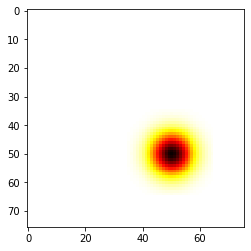

In [164]:
## Initialisation routine example in python. 

def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom
def applyGaussianToField(field,weight,x,y,sigma):
    for i in range(x-3*sigma,x+3*sigma):
        for j in range(y-3*sigma,y+3*sigma):            
            cart_distance = math.sqrt((x-i)**2 +(y-j)**2)
            if i in set(range(0,field.shape[0])) and j in set(range(0, field.shape[1])):
                field[i,j] = 0.1*weight* normpdf(cart_distance,0,sigma) +0.9* field[i,j] 
    return field
def Initialise_tennis_ball_search():
    suspectedLocation = [50,50]
    roverLocation = [0,0]
    width = 1 # width of a grid cell = 0.1m (tuneable)
    sigma = 5 # standard deviation of the guassian
    fudgeFactor =1.5 ## Tuneable!
    x_size = int (fudgeFactor*(suspectedLocation[0]-roverLocation[0])+ 1)
    y_size = int (fudgeFactor*(suspectedLocation[1]-roverLocation[1])+ 1)
    RoverWorld = np.zeros((x_size,y_size))
    
    RoverWorld = applyGaussianToField(RoverWorld,-1.0,suspectedLocation[0],suspectedLocation[1],5)
    return RoverWorld


arr = Initialise_tennis_ball_search()
plt.imshow(arr, cmap='hot', interpolation='nearest')
plt.show()

This is what the rover will know about the world when it first starts up, it will identify the cell of highest interest (Lowest cell index value) and use a minimum cost pathfinding approach
2. **Remap** the rover will scan the environment with its sensors and re update the map using its current estimates. 
    1. Detect any obstacles and/or opportunities with a certain confidence level $p$ and with a certain confidence on the localisation $\sigma_ij$. 
    2. Update the _RoverWorld_ map with the targets and opportunities, scaling them appropriately based on cost. 
3. **Pathfind** Once the map has been updated, recompute the path forward using the new information. 
4. **Move** and iterate the process. 


In [165]:
# Defining obstacles notation x position y position size
obstacles = [(20,20,5,5),(20,40,5,5),(40,20,5,5),(5,40,5,5)]


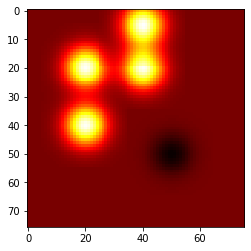

In [166]:
for i in range(len(obstacles)):
    arr = applyGaussianToField(arr,obstacles[i][3],obstacles[i][0],obstacles[i][1],obstacles[i][2])
    
plt.imshow(arr, cmap='hot', interpolation='nearest')
plt.show()

This is an example of how the world will hopefully look from the perspective of the Rover while it is navigating. The remaining task is to pathfind over that graph. We will use the astar algorithm developed by MSP for the 2018 rover to accomplish this. See code below (however, the datails are not super relevant for our purposes here). 

Before anything else we need to select an objective of the rover, for simplicity we will use the minimum of the graph, something more complex (intelligent) could concievably be used though. 

In [167]:
from math import sqrt

def euclidean_heuristic_cost(curr, end,grid):
    """
    Estimates cost from curr (x0,y0) to end (x1,y1) using Euclidean
    distance.
    """
    a = grid[curr[0]][curr[1]]
    ret = (a * sqrt((curr[0]-end[0])**2 + (curr[1]-end[1])**2))
    if ret<0:
        ret = 0
    elif a == 0:
        ret = sqrt((curr[0]-end[0])**2 + (curr[1]-end[1])**2)
    return ret

def reconstruct_path_to_destination(prev, end):
    """
    Constructs an in-order sequence of (x,y) coordinates (list of tuples)
    to the end destination using the mapping from nodes to their predecessors
    (prev).
    """
    path = [end]
    curr = end
    while curr in prev.keys():
        curr = prev[curr]
        path.insert(0, curr)
    return path

def edge_distance_between(node_from, node_to, grid):
    """
    The edge distance between any two nodes is the cost of traversing node_from.
    That is, in this context, node_from is actually irrelevant. We'll retain
    the API for this function as is, however, in case our representation of the
    graph changes in future.
    """
    a = grid[node_to[0]][node_to[1]]# Tuneable parameter to adjust how averse to obstacles the algorithm is.
    return a

def neighbors_of(node, grid):
    """
    The neighbors of a cell (node) in the grid are the 8-surrounding cells.
    """
    neighbors = []

    n_rows = len(grid)
    n_cols = len(grid[0])

    for r_delta in [-1, 0, 1]:
        for c_delta in [-1, 0, 1]:
            r = node[0] + r_delta
            c = node[1] + c_delta

            # skip neighbors that would take us off the edge of the grid
            if r < 0 or r >= n_rows or c < 0 or c >= n_cols:
                continue
            
            # skip the current node itself
            if r_delta == 0 and c_delta == 0:
                continue
            if grid[c][r]>0.1:
                continue
        
            neighbors.append( (r, c) )

    return neighbors

def node_with_min_fscore(open_set, f_cost):
    """
    Find the cell in open set with the smallest f score.
    """
    # TODO: replace this nasty implementation with a heapq
    max_score = 0
    flag = 0 
    for node in open_set:
        if flag is 0:
            flag = 1
            max_node = node
            max_score = f_cost[node]
        if f_cost[node] < max_score:
            max_score = f_cost[node]
            max_node = node
    return max_node

def a_star(grid, start, end, heuristic_cost=euclidean_heuristic_cost):
    """
    Implementation of A Star over a 2D grid. Returns a list of waypoints
    as a list of (x,y) tuples.

    Input:
    : grid, 2D matrix
    : start, (x,y) tuple, start position
    : end, (x,y) tuple, end destination

    Output:
    : waypoints, list of (x,y) tuples
    """
    # the set of cells already evaluated
    closed_set = set()

    # the set of cells already discovered
    open_set = set()
    open_set.add(start)

    # for each cell, mapping to its least-cost incoming cell
    prev = {}
   
    # for each node, cost of reaching it from start (g_cost) 
    # for each node, cost of getting from start to dest via that node (f_cost)
    #   note: cell->dest component of f_cost will be estimated using a heuristic
    g_cost = {}
    f_cost = {}
    for r in range(len(grid)):
        for c in range(len(grid[0])):
            cell = (r, c)
            g_cost[cell] = float("Inf")
            f_cost[cell] = float("Inf")
    g_cost[start] = 0
    f_cost[start] = heuristic_cost(start, end,grid)

    while len(open_set) != 0:
        # node in open set with min fscore
        curr = node_with_min_fscore(open_set, f_cost)
        
        # if we've reached the destination
        if curr == end:
            return reconstruct_path_to_destination(prev, curr)

        open_set.remove(curr)
        closed_set.add(curr)

        
        for neighbor in neighbors_of(curr, grid):
            # ignore neighbors which have already been evaluated
            if neighbor in closed_set:
                continue

            curr_g_score =  g_cost[curr]+ edge_distance_between(curr, neighbor, grid)
            # add neighbor to newly discovered nodes
            if neighbor not in open_set:
                open_set.add(neighbor)

            # if we've already got a lower g_score for neighbor, then move on
            elif curr_g_score >= g_cost[neighbor]:
                continue

            prev[neighbor] = curr
            g_cost[neighbor] = curr_g_score
            f_cost[neighbor] = g_cost[neighbor] + heuristic_cost(neighbor, end,grid)

    # if we get to this point, it's not possible to reach the end destination
    return []



In [168]:
min_index = np.argwhere(arr == np.min(arr))
path = a_star(arr,(0,0),(min_index[0][0],min_index[0][1])) 

We now have a path from the beginning point (0,0) to the end target point (50,50). For simplicity we are assuming that the target is exactly at the place where it is most likely to be. Obviously this does not reflect reality, but we will build to that. The next step is to superimpose the path onto a plot of the grid of threats and opportunities to show that it is navigating appropriately. 

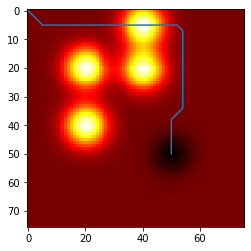

In [169]:
x_pos = []
y_pos = []
for x in path:
    x_pos.append(x[0])
    y_pos.append(x[1])
plt.plot(x_pos,y_pos)
plt.imshow(arr, cmap='hot', interpolation='nearest')
plt.show()

***????**

Now that we have tackled the problem of searching over a known field we need to address the more pressing challenge. Pathfinding over a unknown field. As described above, the strategy will be to update the map that we are pathfinding over, and then run a* on that. For simplicity we will simply say that the rover takes the next position identified by the a star pathfinding algorithm, and then rescans the environment and repeats the process.

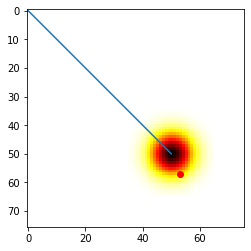

In [170]:
rover_init_postion = (0,0)
ball_location = (53,57) # The actual position of the ball. 
roverWorld = Initialise_tennis_ball_search()

plt.imshow(roverWorld, cmap='hot', interpolation='nearest')
min_index = np.argwhere(roverWorld == np.min(roverWorld))
path_new = a_star(roverWorld,(0,0),(min_index[0][0],min_index[0][1]))
x_pos = []
y_pos = []
for x in path_new:
    x_pos.append(x[0])
    y_pos.append(x[1])
plt.plot(x_pos,y_pos)
plt.plot(ball_location[0],ball_location[1],"ro")
plt.show()

This the first step in the loop, the red dot on the graph represents the actual position of the tennis ball. To make things more challenging we will add 50 obstacles dotted throughout the region, generated randomly.

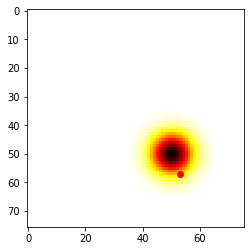

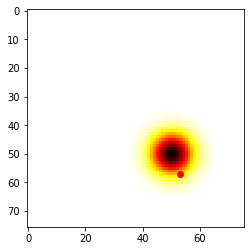

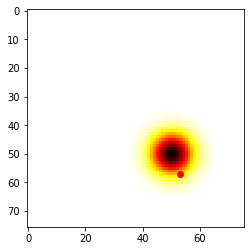

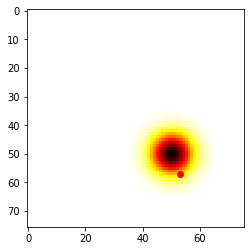

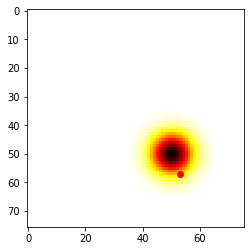

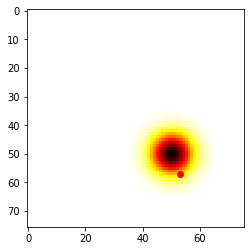

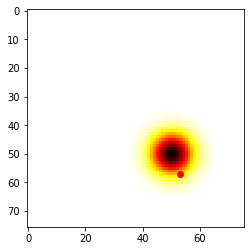

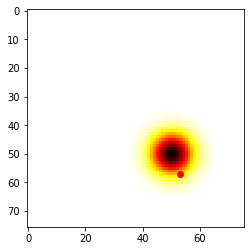

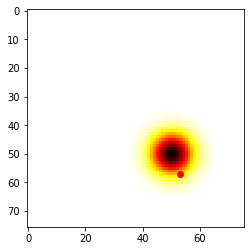

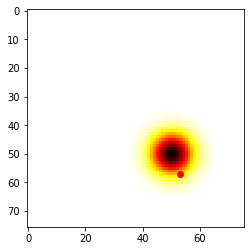

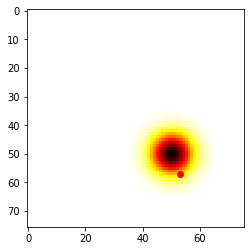

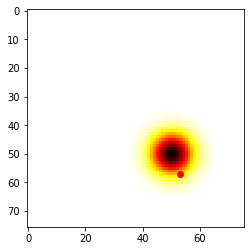

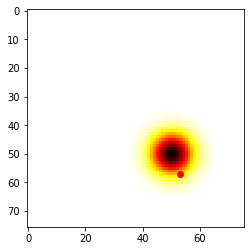

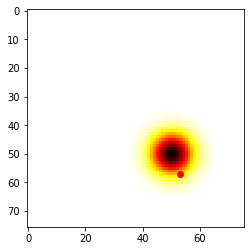

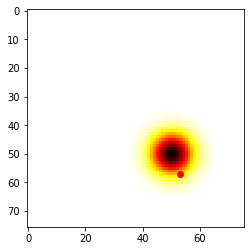

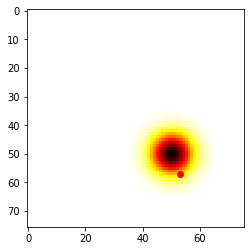

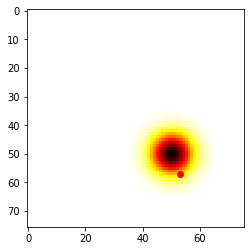

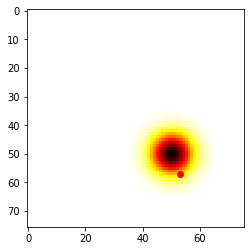

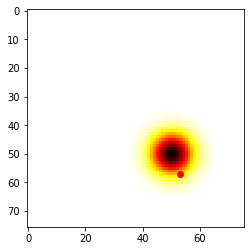

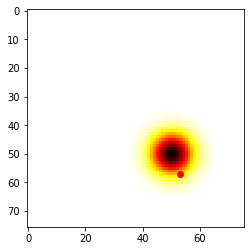

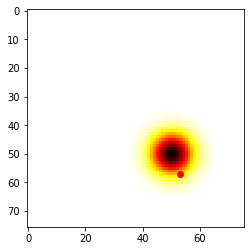

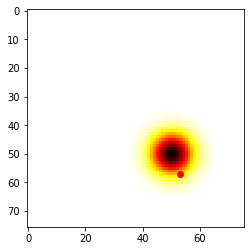

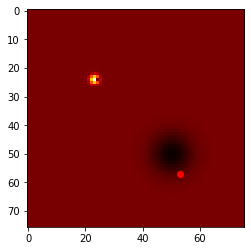

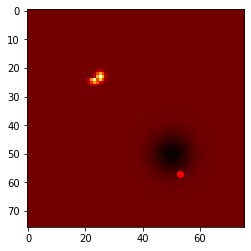

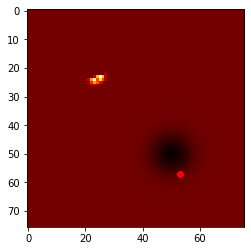

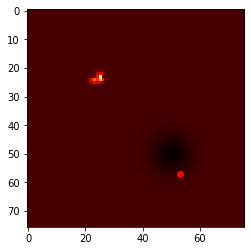

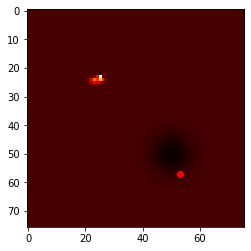

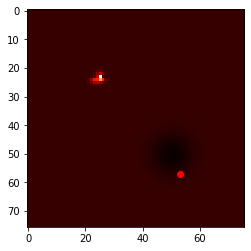

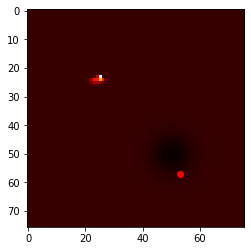

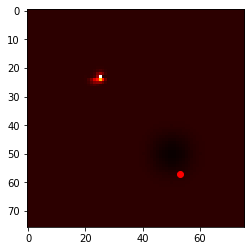

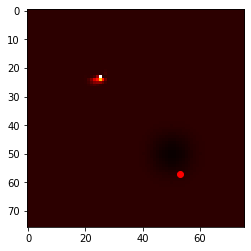

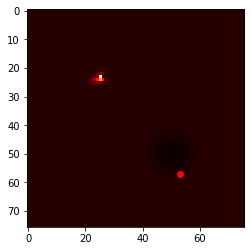

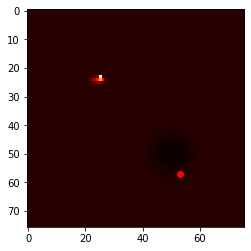

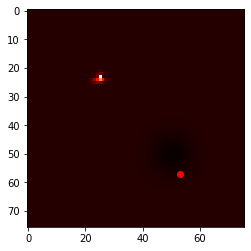

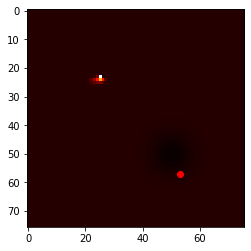

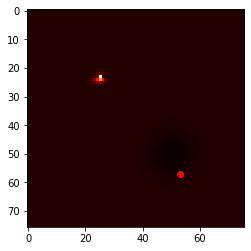

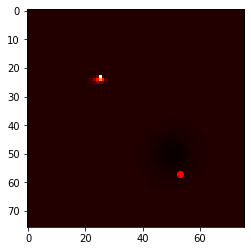

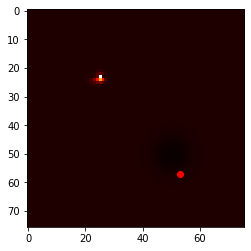

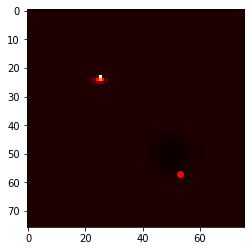

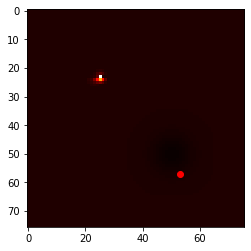

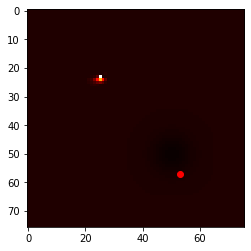

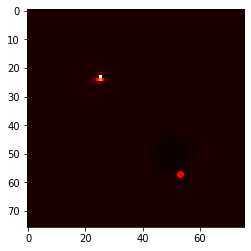

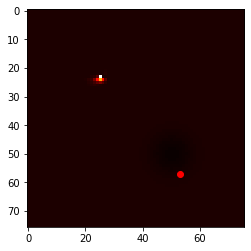

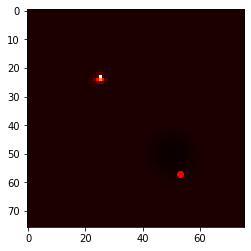

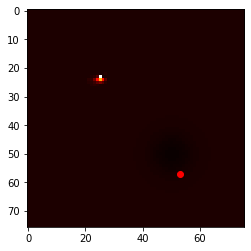

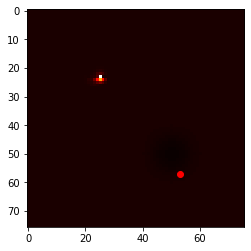

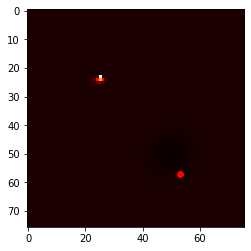

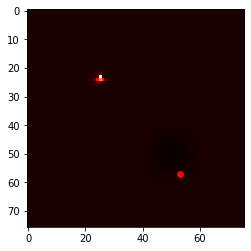

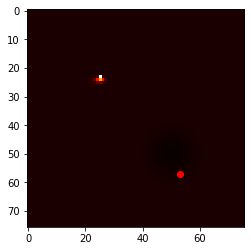

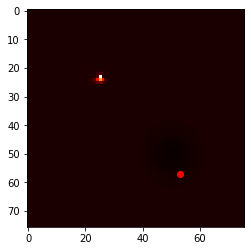

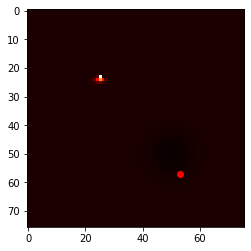

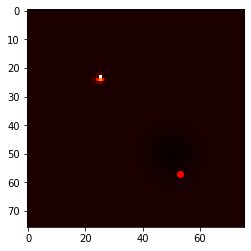

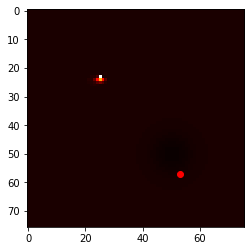

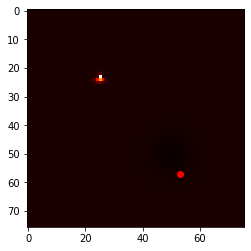

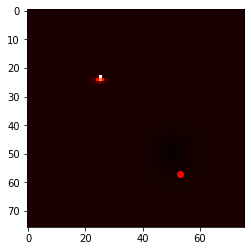

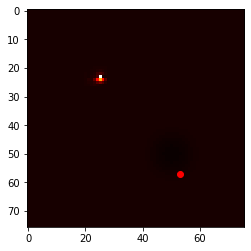

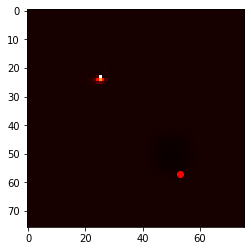

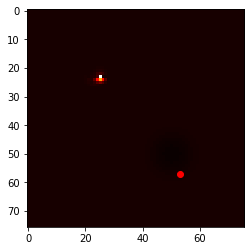

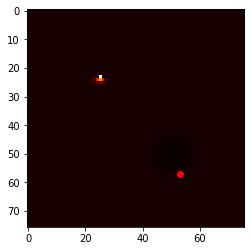

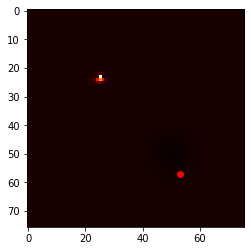

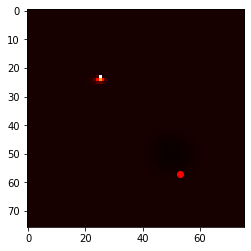

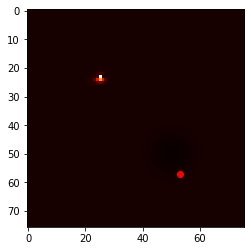

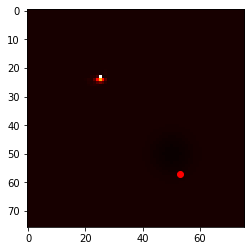

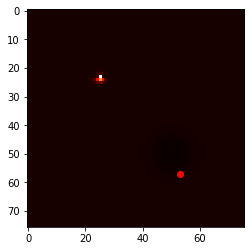

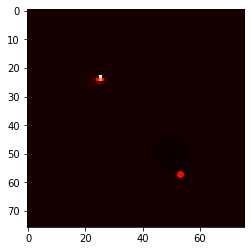

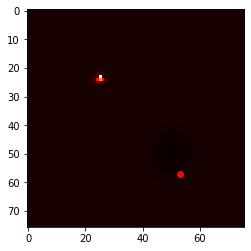

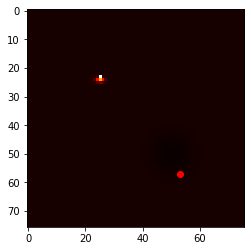

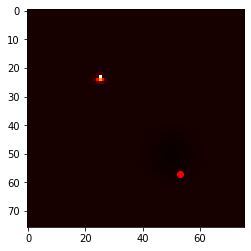

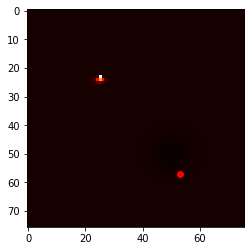

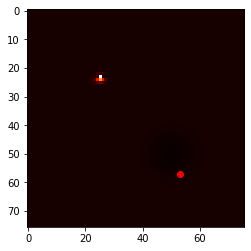

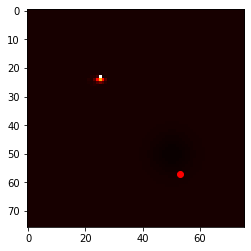

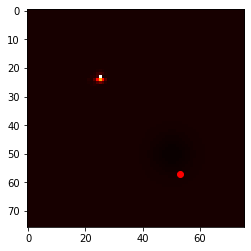

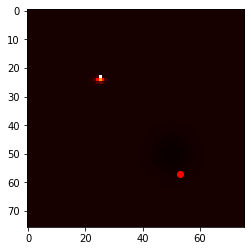

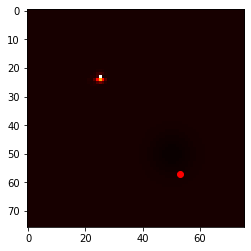

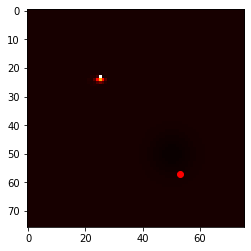

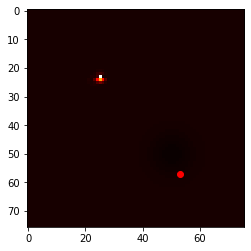

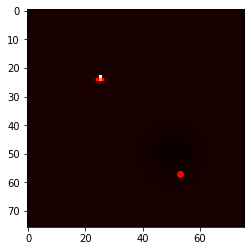

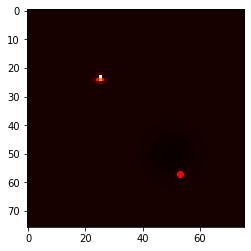

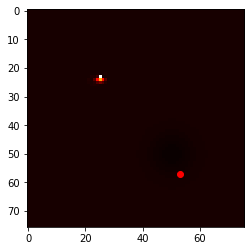

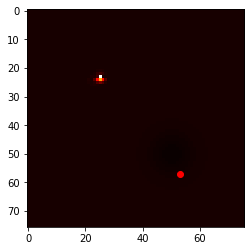

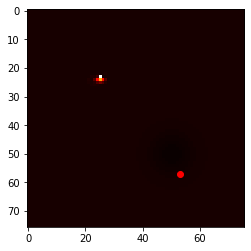

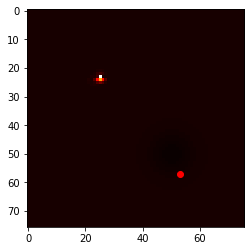

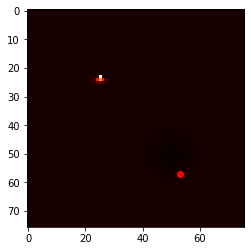

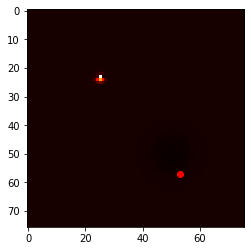

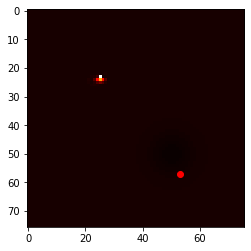

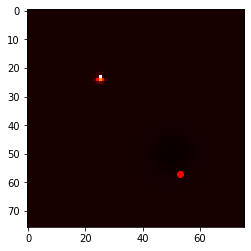

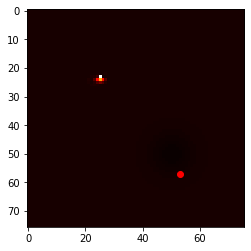

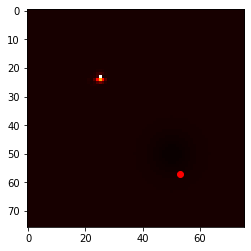

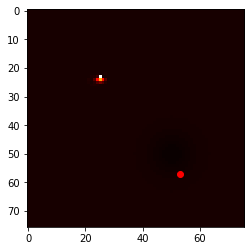

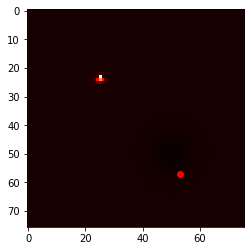

KeyboardInterrupt: 

In [171]:
import random 
random.seed()
unknown_obstacles = [ ( random.randint(0, 70), random.randint(0, 70) ) for k in range(50) ]
unknown = set(unknown_obstacles)

roverLoc = rover_init_postion
def scan(known,obs,pos,tenLoc):
    new = known
    n_rows = len(known)
    n_cols = len(known[0])   
    for r_delta in [-2, -1, 0, 1, 2]:
        for c_delta in [-2,-1, 0, 1,2]:
            r = pos[0] + r_delta
            c = pos[1] + c_delta

            # skip neighbors that would take us off the edge of the grid
            if r < 0 or r >= n_rows or c < 0 or c >= n_cols:
                continue
            if (r,c) in obs:
                new = applyGaussianToField(new,1,r,c,1)
                if (r,c) == tenLoc:
                    print("tennis ball spotted!")
                    new[r,c] = -1
            
            elif (r,c) == tenLoc:
                print("tennis ball spotted!")
                new[r,c] = -1
            
            else:
                new[r,c] = 0
    return new
path = []
while roverLoc != ball_location:
    path.append(roverLoc)
    roverWorld = scan(roverWorld,unknown,roverLoc,ball_location)
    min_index = np.argwhere(roverWorld == np.min(roverWorld))
    path_next = a_star(roverWorld,roverLoc,(min_index[0][0],min_index[0][1]))
    if path_next == []:
        continue
    roverLoc = path_next[1]
    plt.imshow(roverWorld, cmap='hot', interpolation='nearest')
    plt.plot(ball_location[0],ball_location[1],"ro")
    plt.show()

plt.imshow(roverWorld, cmap='hot', interpolation='nearest')
plt.plot(ball_location[0],ball_location[1],"ro")
for x in path:
    x_pos.append(x[0])
    y_pos.append(x[1])
plt.plot(x_pos,y_pos)
plt.show()


We then need to simulate the detection of these obstacles and targets. 